# REGRESSION: Bitcoin Price Forecast

***

<img src="images/BTCUSD_2022-04-07_10-06-24.png">


## INTRODUCTION

This project used data from <b style="color:#4361ee">Kraken API</b> and initially applid one machine learning model, <b style="color:#4361ee">Support Vector Machine</b>, to forcast the future price of <b style="color:#4361ee">Bitcoin.</b>

In [170]:
import numpy as np
import pandas as pd
import json
import datetime
import time
import requests

In [171]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams["font.size"]=14
matplotlib.rcParams["figure.figsize"]= (18,8)
matplotlib.rcParams["figure.facecolor"]="#00000000"

import seaborn as sns
sns.set_style("darkgrid")
import plotly.express as px

## DATA COLLECTION

Kraken gives historical cryptocurrency data. However, the current historical data available is March 31, 2022.
Therefore, additional data need to be pulled from the API market data endpoint.

### 1. Kraken Historical OHLCVT 

* https://support.kraken.com/hc/en-us/articles/360047124832-Downloadable-historical-OHLCVT-Open-High-Low-Close-Volume-Trades-data

* The data given is in one minute timeframe, so we will use the 1440 (daily timeframe)
* The date is in Unix timestamp, so need to be converted to regular date time 

In [172]:
# The columns from the csv file
xbt_cols = ["date","open", "high", "low", "close", "volume", "trades"]

In [173]:
xbt_raw = pd.read_csv("data/XBTUSD_1440.csv", names=xbt_cols)

In [174]:
xbt_raw.head(3)

,date,open,high,low,close,volume,trades
0,1381017600,122.00,122.00,122.00,122.00,0.1000,1
1,1381104000,123.61,123.61,123.61,123.61,0.1000,1
2,1381190400,123.91,124.19,123.90,124.18,3.9916,4


In [175]:
xbt_raw.tail(3)

,date,open,high,low,close,volume,trades
3084,1648512000,47138.3,48123.0,46912.5,47440.2,1877.204974,27843
3085,1648598400,47440.3,47707.9,46570.6,47059.3,1737.317757,25601
3086,1648684800,47079.2,47598.0,45250.0,45524.3,2320.052344,30068


In [176]:
# Convert Unix timestamp
xbt_raw["date"] = pd.to_datetime(xbt_raw["date"],unit='s')

In [177]:
xbt_raw.head(3)

,date,open,high,low,close,volume,trades
0,2013-10-06,122.00,122.00,122.00,122.00,0.1000,1
1,2013-10-07,123.61,123.61,123.61,123.61,0.1000,1
2,2013-10-08,123.91,124.19,123.90,124.18,3.9916,4


In [178]:
xbt_raw.tail(3)

,date,open,high,low,close,volume,trades
3084,2022-03-29,47138.3,48123.0,46912.5,47440.2,1877.204974,27843
3085,2022-03-30,47440.3,47707.9,46570.6,47059.3,1737.317757,25601
3086,2022-03-31,47079.2,47598.0,45250.0,45524.3,2320.052344,30068


In [179]:
xbt_raw.to_csv("data/xbt_raw.csv")

### 2. Kraken API Market data OHLC endpoint
* Using OHLC endpoint for 2022 data
* https://docs.kraken.com/rest/#operation/getTickerInformation
* Unix timestamp converter https://www.epochconverter.com/

In [180]:
# The columns from OHLC API (different from historical data)

kraken_ohlc_cols = ["date","open", "high", "low", "close", "vwap","volume", "trades"]

* Without specifying "since" parameter, the response will give the current day data and only 720 data available

In [181]:
resp = requests.get('https://api.kraken.com/0/public/OHLC?pair=XBTUSD&interval=1440&since=unix_now').json()

In [182]:
xbt_apr22_df = pd.DataFrame(resp["result"]['XXBTZUSD'])

In [183]:
xbt_apr22_df.columns = kraken_ohlc_cols
xbt_apr22_df.head(3)

,date,open,high,low,close,vwap,volume,trades
0,1588032000,7792.4,7794.9,7671.1,7755.8,7729.4,4236.80566423,9992
1,1588118400,7753.0,8978.0,7727.6,8779.9,8403.2,20471.05190692,54201
2,1588204800,8779.9,9487.9,8410.0,8629.6,8933.8,23985.38992569,61295


In [184]:
xbt_apr22_df["date"] = pd.to_datetime(xbt_apr22_df["date"],unit='s')
xbt_apr22_df.head(3)

,date,open,high,low,close,vwap,volume,trades
0,2020-04-28,7792.4,7794.9,7671.1,7755.8,7729.4,4236.80566423,9992
1,2020-04-29,7753.0,8978.0,7727.6,8779.9,8403.2,20471.05190692,54201
2,2020-04-30,8779.9,9487.9,8410.0,8629.6,8933.8,23985.38992569,61295


In [185]:
xbt_apr22_df.tail(3)

,date,open,high,low,close,vwap,volume,trades
717,2022-04-15,39953.7,40890.3,39800.0,40569.9,40290.3,1177.17180956,16024
718,2022-04-16,40570.0,40708.8,40011.9,40381.0,40383.5,589.46381724,12703
719,2022-04-17,40381.1,40652.8,40147.0,40466.3,40431.9,432.11300789,6522


### Appending data from OHLC API to dataframe from historical data

<b>Drop vwap column since there's no vwap column in the historical data</b>

In [186]:
# Drop vwap column since there's no vwap column in the historical data

xbt_apr22_df.drop("vwap", axis=1, inplace=True)
xbt_apr22_df.head(3)

,date,open,high,low,close,volume,trades
0,2020-04-28,7792.4,7794.9,7671.1,7755.8,4236.80566423,9992
1,2020-04-29,7753.0,8978.0,7727.6,8779.9,20471.05190692,54201
2,2020-04-30,8779.9,9487.9,8410.0,8629.6,23985.38992569,61295


<b> Select the data after March 31,2022 </b>

In [187]:
xbt_apr22 = xbt_apr22_df[xbt_apr22_df["date"] > "2022-03-31"]
xbt_apr22

,date,open,high,low,close,volume,trades
703,2022-04-01,45523.5,46710.9,44257.6,46312.0,4181.29834325,36546
704,2022-04-02,46312.0,47200.0,45666.1,45828.6,1420.18952030,22824
705,2022-04-03,45828.6,47444.9,45566.0,46423.4,1245.97997739,20620
706,2022-04-04,46424.2,46888.0,45153.0,46617.1,1910.97459708,23949
707,2022-04-05,46617.1,47188.4,45377.0,45479.2,1882.88025051,22655
708,2022-04-06,45498.3,45534.3,43123.7,43179.4,4589.10698672,36043
709,2022-04-07,43179.5,43920.8,42750.0,43469.8,1565.17601256,22151
710,2022-04-08,43469.8,43968.7,42126.0,42282.6,2238.74341635,26125
711,2022-04-09,42282.6,42805.1,42111.0,42764.0,621.74608186,13343
712,2022-04-10,42781.7,43416.4,41805.4,42160.0,1121.27095145,15302


<b> Combine the two dataframes</b>

In [188]:
btc_df_raw = pd.concat([xbt_raw, xbt_apr22],ignore_index=True)

In [189]:
btc_df_raw.head(3)

,date,open,high,low,close,volume,trades
0,2013-10-06,122.0,122.0,122.0,122.0,0.1,1
1,2013-10-07,123.61,123.61,123.61,123.61,0.1,1
2,2013-10-08,123.91,124.19,123.9,124.18,3.9916,4


In [190]:
btc_df_raw.tail(3)

,date,open,high,low,close,volume,trades
3101,2022-04-15,39953.7,40890.3,39800.0,40569.9,1177.17180956,16024
3102,2022-04-16,40570.0,40708.8,40011.9,40381.0,589.46381724,12703
3103,2022-04-17,40381.1,40652.8,40147.0,40466.3,432.11300789,6522


In [191]:
btc_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3104 entries, 0 to 3103
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3104 non-null   datetime64[ns]
 1   open    3104 non-null   object        
 2   high    3104 non-null   object        
 3   low     3104 non-null   object        
 4   close   3104 non-null   object        
 5   volume  3104 non-null   object        
 6   trades  3104 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 169.9+ KB


In [192]:
btc_df_raw = btc_df_raw.astype({"open":"float64", 
                               "high":"float64", 
                                "low":"float64", 
                               "close":"float64", 
                             "volume":"float64"})

In [193]:
btc_df_raw.to_csv("data/btc_df_raw.csv") # save data for later use


## DATA PREPROCESSING


### Create more features 

In [194]:
btc_df = pd.read_csv("data/btc_df_raw.csv", index_col=0)

In [195]:
btc_df.head(2)

,date,open,high,low,close,volume,trades
0,2013-10-06,122.00,122.00,122.00,122.00,0.1,1
1,2013-10-07,123.61,123.61,123.61,123.61,0.1,1


In [196]:
btc_df.tail(2)

,date,open,high,low,close,volume,trades
3102,2022-04-16,40570.0,40708.8,40011.9,40381.0,589.463817,12703
3103,2022-04-17,40381.1,40652.8,40147.0,40466.3,432.113008,6522


In [197]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3104 entries, 0 to 3103
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3104 non-null   object 
 1   open    3104 non-null   float64
 2   high    3104 non-null   float64
 3   low     3104 non-null   float64
 4   close   3104 non-null   float64
 5   volume  3104 non-null   float64
 6   trades  3104 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 194.0+ KB


#### Split date column to year, month, day

In [198]:
def date_split(df):
    df["date"] = pd.to_datetime(df["date"])
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    return(df)

In [199]:
btc_df = date_split(btc_df)

In [200]:
btc_df = btc_df[["date","year", "month", "day", "open", "high", "low", "close", "volume", "trades"]]

In [201]:
btc_df.head(3)

,date,year,month,day,open,high,low,close,volume,trades
0,2013-10-06,2013,10,6,122.00,122.00,122.00,122.00,0.1000,1
1,2013-10-07,2013,10,7,123.61,123.61,123.61,123.61,0.1000,1
2,2013-10-08,2013,10,8,123.91,124.19,123.90,124.18,3.9916,4


In [202]:
btc_df = btc_df.set_index("date")

In [203]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades
date,,,,,,,,,
2013-10-06,2013,10,6,122.00,122.00,122.00,122.00,0.1000,1
2013-10-07,2013,10,7,123.61,123.61,123.61,123.61,0.1000,1
2013-10-08,2013,10,8,123.91,124.19,123.90,124.18,3.9916,4


#### Adding Yesterday prices, volume, trades

In [204]:
def yesterday_data(df):
    df["open_yesterday"] = df["open"].shift(1)
    df["high_yesterday"] = df["high"].shift(1)
    df["low_yesterday"] = df["low"].shift(1)
    df["close_yesterday"] = df["close"].shift(1)
    df["volume_yesterday"] = df["volume"].shift(1)
    df["trades_yesterday"] = df["trades"].shift(1)
    return(df)

In [205]:
btc_df = yesterday_data(btc_df)

#### Adding % change of yesterday and the day before yesterday

price_1D_change = (today_price - yesterday_price)/yesterday_price

In [206]:
def change_1D(df):
    df["open_1D_change"] = btc_df["open"].pct_change().shift(1)
    df["high_1D_change"] = btc_df["high"].pct_change().shift(1)
    df["low_1D_change"]  = df["low"].pct_change().shift(1)
    df["close_1D_change"] = df["close"].pct_change().shift(1)
    df["volume_1D_change"] = df["volume"].pct_change().shift(1)
    df["trades_1D_change"] = df["trades"].pct_change().shift(1)
    return(df)
    

In [207]:
btc_df = change_1D(btc_df)

#### Average 7 days

- rolling will include the current row to calculate
- so if we are at row#8 (index=7), we can calculate mean of the first 7 rows 
- then shiff the value to row#8

In [208]:
def moving_ave_7(df):
    df["open_average_7D"] = df["open"].rolling(7).mean().shift(1)
    df["high_average_7D"] = df["high"].rolling(7).mean().shift(1)
    df["low_average_7D"] = df["low"].rolling(7).mean().shift(1)
    df["close_average_7D"] = df["close"].rolling(7).mean().shift(1)
    df["volume_average_7D"] = df["volume"].rolling(7).mean().shift(1)
    df["trades_average_7D"] = df["trades"].rolling(7).mean().shift(1)
    
    return(df)

In [209]:
btc_df = moving_ave_7(btc_df)

#### % change 7 days

In [210]:
def change_pct_7D(df):
    df["open_%change_7D"] = df["open_1D_change"].rolling(7).mean().shift(1)
    df["high_%change_7D"] = df["high_1D_change"].rolling(7).mean().shift(1)
    df["low_%change_7D"] = df["low_1D_change"].rolling(7).mean().shift(1)
    df["close_%change_7D"] = df["close_1D_change"].rolling(7).mean().shift(1)
    df["volume_%change_7D"] = df["volume_1D_change"].rolling(7).mean().shift(1)
    df["trades_%change_7D"] = df["trades_1D_change"].rolling(7).mean().shift(1)
    
    return(df)

In [211]:
btc_df = change_pct_7D(btc_df)

#### Simple Moving Average 9, 20, 50
- Will only use ["close"] here

In [212]:
def moving_avgs_pop(df):
    df["moving_average_9"] = df["close"].rolling(9).mean().shift(1)
    df["moving_average_20"] = df["close"].rolling(20).mean().shift(1)
    df["moving_average_50"] = df["close"].rolling(50).mean().shift(1)
    
    return(df)

In [213]:
btc_df = moving_avgs_pop(btc_df)

<b> Set the display to see all columns </b>

In [214]:
pd.set_option("display.max_columns", len(btc_df.columns))

In [215]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-10-06,2013,10,6,122.00,122.00,122.00,122.00,0.1000,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-07,2013,10,7,123.61,123.61,123.61,123.61,0.1000,1,122.00,122.00,122.00,122.00,0.1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-08,2013,10,8,123.91,124.19,123.90,124.18,3.9916,4,123.61,123.61,123.61,123.61,0.1,1.0,0.013197,0.013197,0.013197,0.013197,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [216]:
btc_df.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-15,2022,4,15,39953.7,40890.3,39800.0,40569.9,1177.171810,16024,41150.0,41480.0,39600.0,39954.9,1895.263567,20685.0,0.026730,-0.001646,0.000051,-0.029043,-0.214975,-0.138771,41636.885714,42330.428571,40535.685714,41132.114286,1966.503009,22213.571429,-0.017540,-0.012737,-0.011875,-0.006443,0.224060,0.040083,41619.333333,44189.960,42072.390
2022-04-16,2022,4,16,40570.0,40708.8,40011.9,40381.0,589.463817,12703,39953.7,40890.3,39800.0,40569.9,1177.171810,16024.0,-0.029072,-0.014216,0.005051,0.015392,-0.378888,-0.225332,41134.585714,41890.657143,40203.400000,40887.442857,1814.849922,20770.571429,-0.006440,-0.007910,-0.010630,-0.011553,0.287483,0.075320,41329.388889,43991.055,42116.972
2022-04-17,2022,4,17,40381.1,40652.8,40147.0,40466.3,432.113008,6522,40570.0,40708.8,40011.9,40381.0,589.463817,12703.0,0.015425,-0.004439,0.005324,-0.004656,-0.499254,-0.207252,40889.928571,41591.185714,39903.528571,40547.014286,1810.238170,20679.142857,-0.011554,-0.010097,-0.007823,-0.005453,0.171878,0.017501,40986.188889,43667.345,42139.922


#### Drop NaN

In [217]:
len(btc_df)

3104

In [218]:
btc_df = btc_df.dropna()

In [219]:
len(btc_df)

3054

In [220]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [221]:
btc_df.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-15,2022,4,15,39953.7,40890.3,39800.0,40569.9,1177.171810,16024,41150.0,41480.0,39600.0,39954.9,1895.263567,20685.0,0.026730,-0.001646,0.000051,-0.029043,-0.214975,-0.138771,41636.885714,42330.428571,40535.685714,41132.114286,1966.503009,22213.571429,-0.017540,-0.012737,-0.011875,-0.006443,0.224060,0.040083,41619.333333,44189.960,42072.390
2022-04-16,2022,4,16,40570.0,40708.8,40011.9,40381.0,589.463817,12703,39953.7,40890.3,39800.0,40569.9,1177.171810,16024.0,-0.029072,-0.014216,0.005051,0.015392,-0.378888,-0.225332,41134.585714,41890.657143,40203.400000,40887.442857,1814.849922,20770.571429,-0.006440,-0.007910,-0.010630,-0.011553,0.287483,0.075320,41329.388889,43991.055,42116.972
2022-04-17,2022,4,17,40381.1,40652.8,40147.0,40466.3,432.113008,6522,40570.0,40708.8,40011.9,40381.0,589.463817,12703.0,0.015425,-0.004439,0.005324,-0.004656,-0.499254,-0.207252,40889.928571,41591.185714,39903.528571,40547.014286,1810.238170,20679.142857,-0.011554,-0.010097,-0.007823,-0.005453,0.171878,0.017501,40986.188889,43667.345,42139.922


#### Save dataframe for later use for Machine Learaning model

In [222]:
btc_df.to_csv("data/btc_df.csv")

# VISUALIZATION

In [223]:
btc_df.head(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,2013,11,27,893.90000,1081.09181,890.00000,994.95000,46.413145,782,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,2013,11,28,994.95000,1088.41486,935.08060,1000.32893,33.030364,443,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,2013,11,29,1012.39302,1198.80090,1012.39302,1165.42500,34.827289,562,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [224]:
btc_df.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-15,2022,4,15,39953.7,40890.3,39800.0,40569.9,1177.171810,16024,41150.0,41480.0,39600.0,39954.9,1895.263567,20685.0,0.026730,-0.001646,0.000051,-0.029043,-0.214975,-0.138771,41636.885714,42330.428571,40535.685714,41132.114286,1966.503009,22213.571429,-0.017540,-0.012737,-0.011875,-0.006443,0.224060,0.040083,41619.333333,44189.960,42072.390
2022-04-16,2022,4,16,40570.0,40708.8,40011.9,40381.0,589.463817,12703,39953.7,40890.3,39800.0,40569.9,1177.171810,16024.0,-0.029072,-0.014216,0.005051,0.015392,-0.378888,-0.225332,41134.585714,41890.657143,40203.400000,40887.442857,1814.849922,20770.571429,-0.006440,-0.007910,-0.010630,-0.011553,0.287483,0.075320,41329.388889,43991.055,42116.972
2022-04-17,2022,4,17,40381.1,40652.8,40147.0,40466.3,432.113008,6522,40570.0,40708.8,40011.9,40381.0,589.463817,12703.0,0.015425,-0.004439,0.005324,-0.004656,-0.499254,-0.207252,40889.928571,41591.185714,39903.528571,40547.014286,1810.238170,20679.142857,-0.011554,-0.010097,-0.007823,-0.005453,0.171878,0.017501,40986.188889,43667.345,42139.922


In [225]:
btc_df_viz = btc_df[:-1]  # drop last row because the trading day isn't closed yet

In [226]:
btc_df_viz.tail(3)

,year,month,day,open,high,low,close,volume,trades,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-14,2022,4,14,41150.0,41480.0,39600.0,39954.9,1895.263567,20685,40078.7,41548.4,39598.0,41150.0,2414.270577,24018.0,0.013868,0.021262,0.008368,0.026730,0.112399,-0.010342,41926.814286,42679.114286,40985.685714,41634.242857,1919.347644,22423.000000,-0.022949,-0.020782,-0.020164,-0.017486,0.413328,0.125982,42233.144444,44407.990,42018.294
2022-04-15,2022,4,15,39953.7,40890.3,39800.0,40569.9,1177.171810,16024,41150.0,41480.0,39600.0,39954.9,1895.263567,20685.0,0.026730,-0.001646,0.000051,-0.029043,-0.214975,-0.138771,41636.885714,42330.428571,40535.685714,41132.114286,1966.503009,22213.571429,-0.017540,-0.012737,-0.011875,-0.006443,0.224060,0.040083,41619.333333,44189.960,42072.390
2022-04-16,2022,4,16,40570.0,40708.8,40011.9,40381.0,589.463817,12703,39953.7,40890.3,39800.0,40569.9,1177.171810,16024.0,-0.029072,-0.014216,0.005051,0.015392,-0.378888,-0.225332,41134.585714,41890.657143,40203.400000,40887.442857,1814.849922,20770.571429,-0.006440,-0.007910,-0.010630,-0.011553,0.287483,0.075320,41329.388889,43991.055,42116.972


<b> Close Price Trend </b>

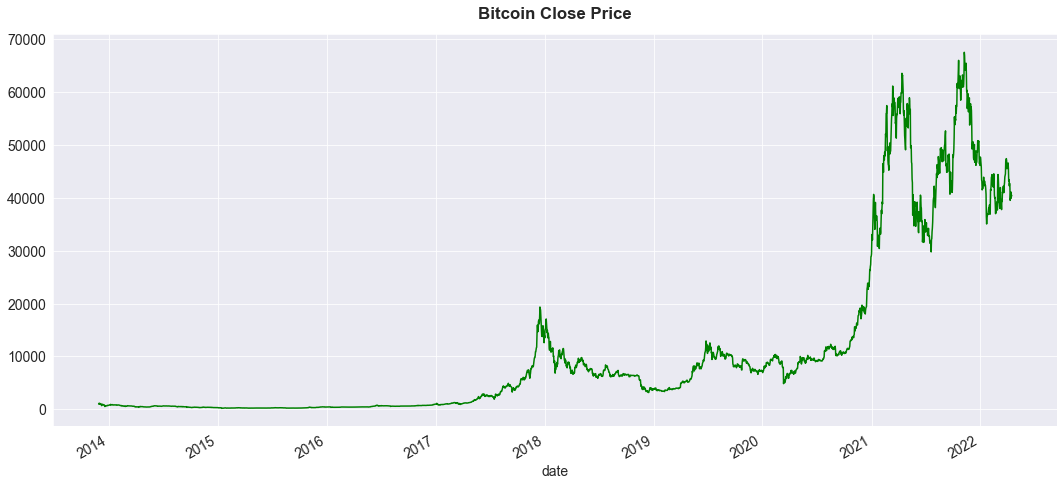

In [227]:
btc_df_viz['close'].plot(color="green") 
plt.title("Bitcoin Close Price", fontweight="bold", y=1.025)#fontname="Times New Roman"
plt.show()

<b> Volume Trend </b>

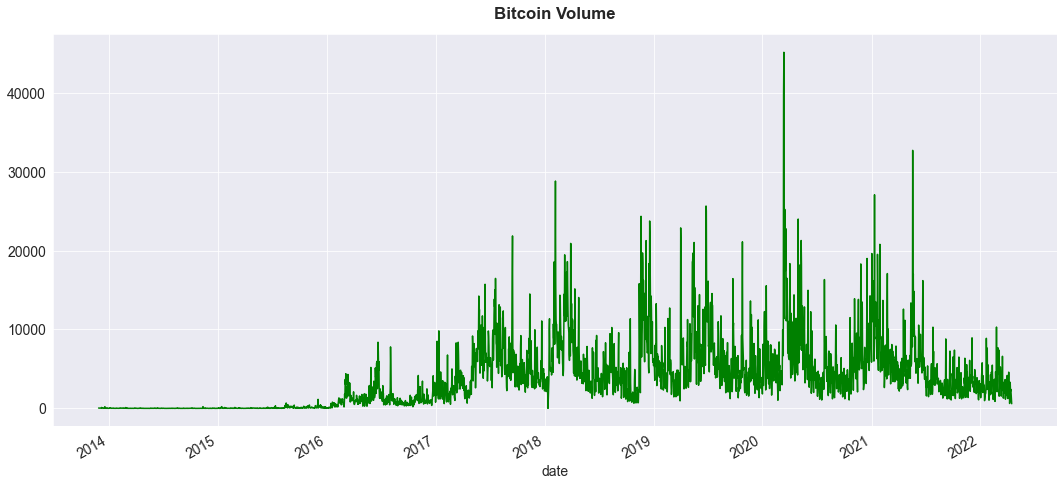

In [228]:
btc_df_viz['volume'].plot(color="green")
plt.title("Bitcoin Volume", fontweight="bold", y=1.025)
plt.show()

<b> Trades Trend </b>

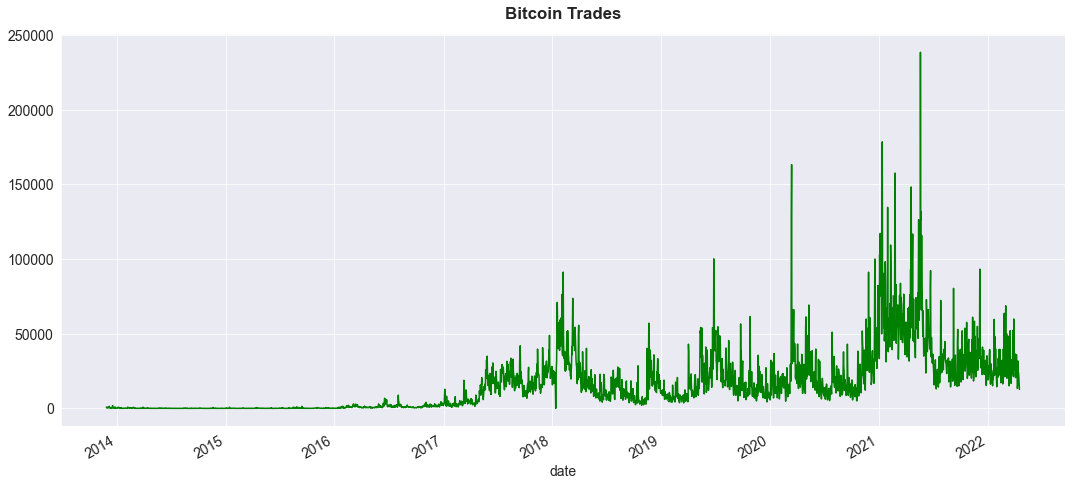

In [229]:
btc_df_viz['trades'].plot(color="green")
plt.title("Bitcoin Trades", fontweight="bold", y=1.025)
plt.show()

<b> Box Plot Close Price </b>

Text(0, 0.5, '')

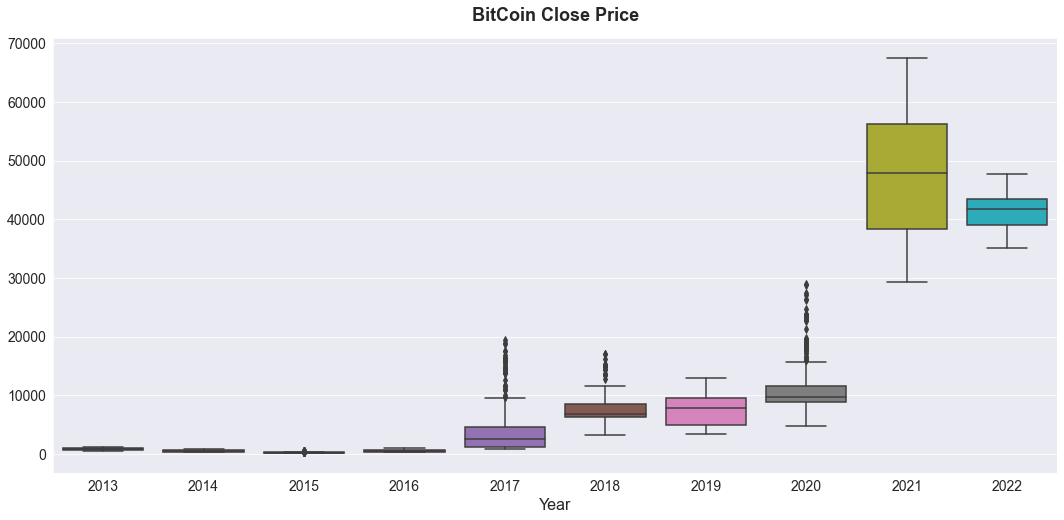

In [230]:
box = sns.boxplot(x=btc_df_viz["year"], y=btc_df_viz["close"], data=btc_df_viz)

box.set_title("BitCoin Close Price",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box.set_xlabel("Year", fontsize=16)
box.set_ylabel(None, fontsize=16)


<b> Box Plot Volume </b>

Text(0, 0.5, '')

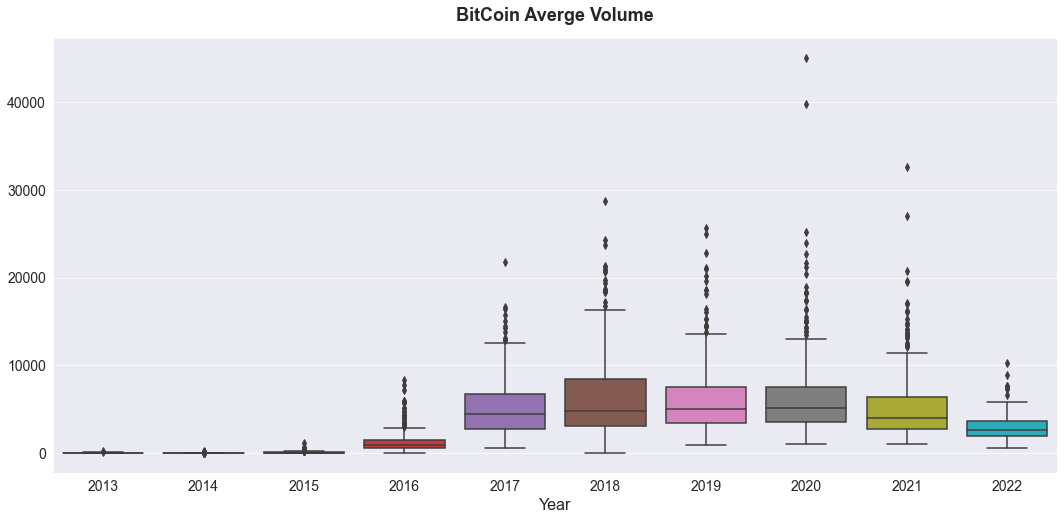

In [231]:
box1 = sns.boxplot(x=btc_df_viz["year"], y=btc_df_viz["volume"], data=btc_df_viz)

box1.set_title("BitCoin Averge Volume",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box1.set_xlabel("Year", fontsize=16)
box1.set_ylabel(None, fontsize=16)


<b> Box Plot Trades </b>

Text(0, 0.5, '')

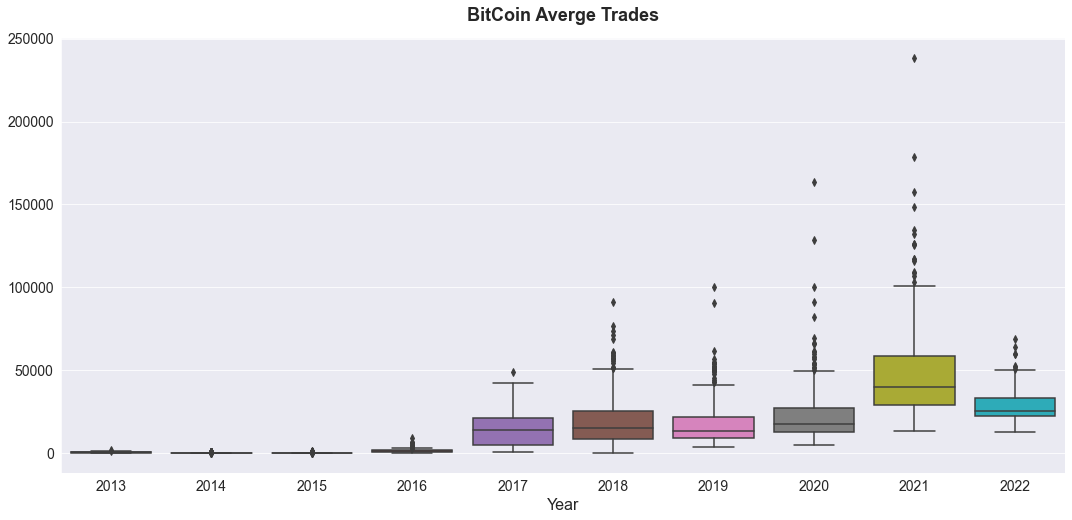

In [232]:
box2 = sns.boxplot(x=btc_df_viz["year"], y=btc_df_viz["trades"], data=btc_df_viz)

box2.set_title("BitCoin Averge Trades",y=1.025, fontdict= {'fontweight':'bold',"fontsize":18})
box2.set_xlabel("Year", fontsize=16)
box2.set_ylabel(None, fontsize=16)

In [233]:
btc_avg = pd.DataFrame(btc_df_viz.groupby(['year'])['open'].mean())
btc_avg["high"] = pd.DataFrame(btc_df_viz.groupby(['year'])['high'].mean())
btc_avg["low"] = pd.DataFrame(btc_df_viz.groupby(['year'])['low'].mean())
btc_avg["close"] = pd.DataFrame(btc_df_viz.groupby(['year'])['close'].mean())
btc_avg["volume"] = pd.DataFrame(btc_df_viz.groupby(['year'])['volume'].mean())
btc_avg["trades"] = pd.DataFrame(btc_df_viz.groupby(['year'])['trades'].mean())
btc_avg

,open,high,low,close,volume,trades
year,,,,,,
2013,834.430256,887.545685,763.786884,828.310699,43.388851,489.028571
2014,533.016193,548.639927,515.940908,531.499985,14.195329,102.535211
2015,271.471425,278.831813,265.153542,272.323858,77.278983,122.101370
2016,566.870884,576.048015,557.450315,568.276695,1283.666737,1306.759563
2017,3936.776534,4118.183701,3767.023499,3972.502397,5048.121496,14161.161644
2018,7552.732329,7783.027671,7258.388493,7523.407671,6301.052699,19339.312329
2019,7355.562466,7562.660548,7131.104658,7364.964110,6106.849901,17539.893151
2020,11056.251366,11336.646721,10783.763934,11116.068579,6386.292323,22526.715847
2021,47378.112329,48812.425753,45668.609041,47426.086301,5254.154224,47278.846575


<b>Yearly Average Close Price </b>

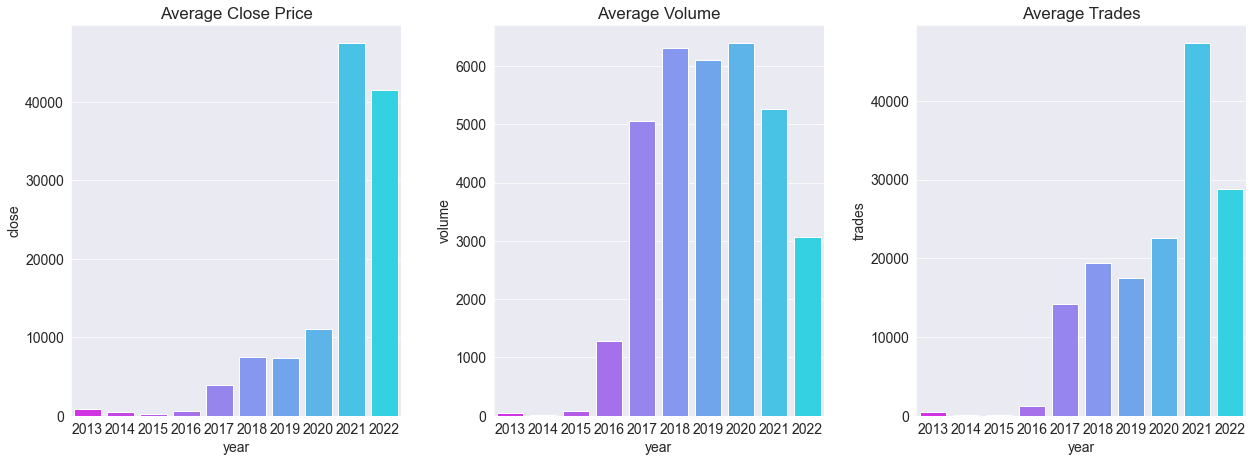

In [234]:
fig, axes = plt.subplots(1,3, figsize=(18,7))

axes[0].set_title("Average Close Price")
sns.barplot(ax=axes[0], data = btc_avg, x = btc_avg.index, y=btc_avg["close"], palette="cool_r")

axes[1].set_title("Average Volume")
sns.barplot(ax=axes[1], data = btc_avg, x = btc_avg.index, y=btc_avg["volume"],palette="cool_r")


axes[2].set_title("Average Trades",)
sns.barplot(ax=axes[2], data = btc_avg, x = btc_avg.index, y=btc_avg["trades"],palette="cool_r")


plt.tight_layout(pad=2)

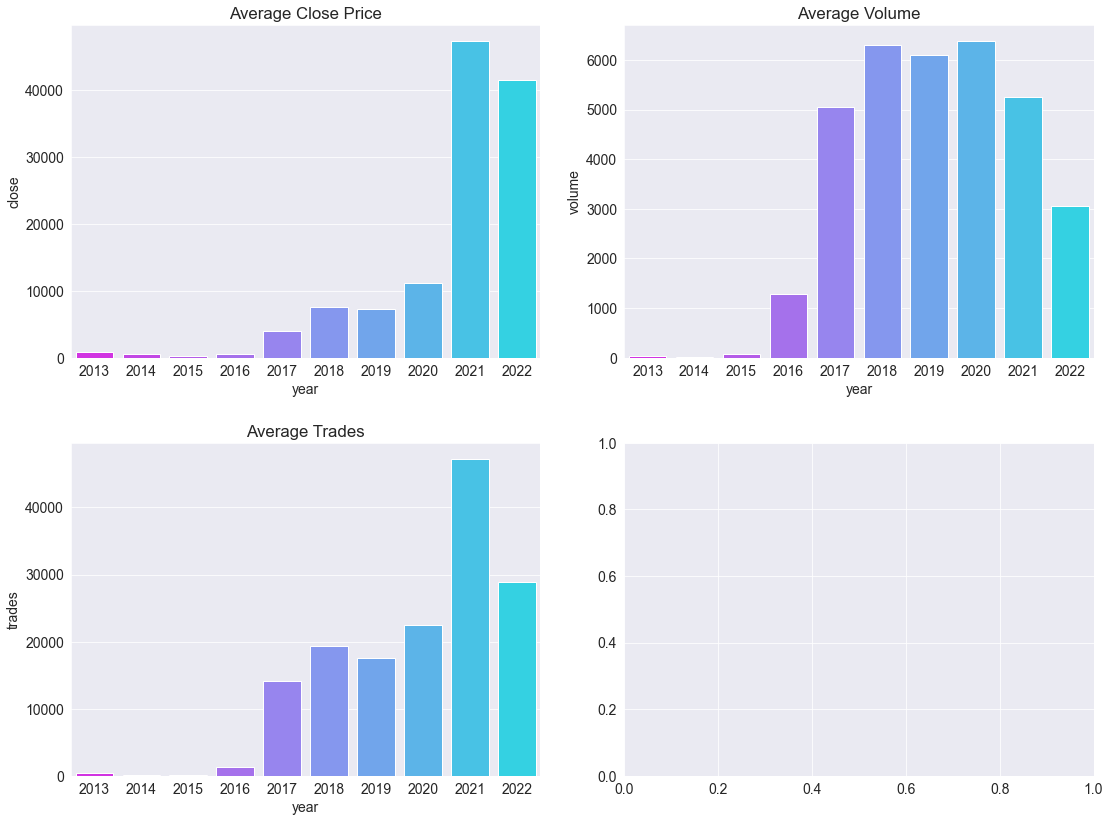

In [235]:
fig, axes = plt.subplots(2,2, figsize=(16,12))

axes[0,0].set_title("Average Close Price")
sns.barplot(ax=axes[0,0], data = btc_avg, x = btc_avg.index, y=btc_avg["close"], palette="cool_r")

axes[0,1].set_title("Average Volume")
sns.barplot(ax=axes[0,1], data = btc_avg, x = btc_avg.index, y=btc_avg["volume"],palette="cool_r")


axes[1,0].set_title("Average Trades",)
sns.barplot(ax=axes[1,0], data = btc_avg, x = btc_avg.index, y=btc_avg["trades"],palette="cool_r")


plt.tight_layout(pad=2)

In [236]:
df_2013 = btc_df_viz[btc_df_viz["year"]==2013]
df_2014 = btc_df_viz[btc_df_viz["year"]==2014]
df_2015 = btc_df_viz[btc_df_viz["year"]==2015]
df_2016 = btc_df_viz[btc_df_viz["year"]==2016]
df_2017 = btc_df_viz[btc_df_viz["year"]==2017]
df_2018 = btc_df_viz[btc_df_viz["year"]==2018]
df_2019 = btc_df_viz[btc_df_viz["year"]==2019]
df_2020 = btc_df_viz[btc_df_viz["year"]==2020]
df_2021 = btc_df_viz[btc_df_viz["year"]==2021]
df_2022 = btc_df_viz[btc_df_viz["year"]==2022]

#### Heatmap showing  correlation score

In [237]:
cor_df= btc_df_viz.corr()

<AxesSubplot:>

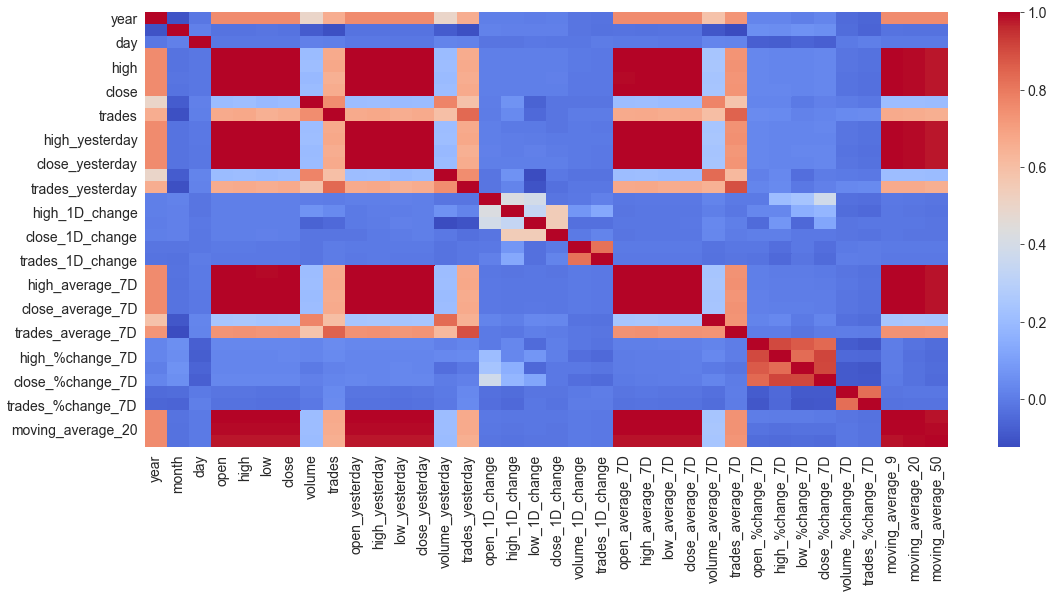

In [238]:
sns.heatmap(cor_df, cmap="coolwarm")

#### DataFrame with Dropping some Features

In [239]:
btc_df_less_features = btc_df.drop(["year", "month", "day"], axis=1) # not important

In [240]:
btc_df_less_features = btc_df_less_features.drop(["open", "high", "low","trades", "volume"], axis=1) 

# in reality, we don't know this on the current day or tomorrow day we want to predict
# we only know yesterday'open, yesterday'high, yesterday's low, and yesterday's close

In [241]:
btc_df_less_features.head(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,1165.42500,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


<b> Save dataframe for machine learning model </b>

In [242]:
btc_df_less_features.to_csv("data/btc_df_less_features.csv")

## MACHINE LEARNING MODEL

* Split train-test data using date since it's a time series data

* not using train-test-split from sklearn since it will mix up the data

In [243]:
btc_ml_all = pd.read_csv("data/btc_df_less_features.csv", index_col=0)

In [244]:
btc_ml_all.head(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,1165.42500,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [245]:
btc_ml_all.tail(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-15,40569.9,41150.0,41480.0,39600.0,39954.9,1895.263567,20685.0,0.026730,-0.001646,0.000051,-0.029043,-0.214975,-0.138771,41636.885714,42330.428571,40535.685714,41132.114286,1966.503009,22213.571429,-0.017540,-0.012737,-0.011875,-0.006443,0.224060,0.040083,41619.333333,44189.960,42072.390
2022-04-16,40381.0,39953.7,40890.3,39800.0,40569.9,1177.171810,16024.0,-0.029072,-0.014216,0.005051,0.015392,-0.378888,-0.225332,41134.585714,41890.657143,40203.400000,40887.442857,1814.849922,20770.571429,-0.006440,-0.007910,-0.010630,-0.011553,0.287483,0.075320,41329.388889,43991.055,42116.972
2022-04-17,40466.3,40570.0,40708.8,40011.9,40381.0,589.463817,12703.0,0.015425,-0.004439,0.005324,-0.004656,-0.499254,-0.207252,40889.928571,41591.185714,39903.528571,40547.014286,1810.238170,20679.142857,-0.011554,-0.010097,-0.007823,-0.005453,0.171878,0.017501,40986.188889,43667.345,42139.922


#### Drop the last row because we want to predict the price of the current day

In [246]:
last_row = btc_ml_all[-1:]
last_row

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-17,40466.3,40570.0,40708.8,40011.9,40381.0,589.463817,12703.0,0.015425,-0.004439,0.005324,-0.004656,-0.499254,-0.207252,40889.928571,41591.185714,39903.528571,40547.014286,1810.23817,20679.142857,-0.011554,-0.010097,-0.007823,-0.005453,0.171878,0.017501,40986.188889,43667.345,42139.922


In [247]:
btc_ml = btc_ml_all[:-1]
btc_ml.head(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435


In [248]:
btc_ml.tail(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-15,40569.9,41150.0,41480.0,39600.0,39954.9,1895.263567,20685.0,0.026730,-0.001646,0.000051,-0.029043,-0.214975,-0.138771,41636.885714,42330.428571,40535.685714,41132.114286,1966.503009,22213.571429,-0.01754,-0.012737,-0.011875,-0.006443,0.224060,0.040083,41619.333333,44189.960,42072.390
2022-04-16,40381.0,39953.7,40890.3,39800.0,40569.9,1177.171810,16024.0,-0.029072,-0.014216,0.005051,0.015392,-0.378888,-0.225332,41134.585714,41890.657143,40203.400000,40887.442857,1814.849922,20770.571429,-0.00644,-0.007910,-0.010630,-0.011553,0.287483,0.075320,41329.388889,43991.055,42116.972


#### Split train-test 85:15
* Can't use train-test split because it will shuffle the data/date index

In [249]:
len(btc_ml)

3053

In [250]:
train_size = (85*(len(btc_ml)))//100
train_size

2595

**Train Set**

In [251]:
train_set = btc_ml.iloc[0:train_size]
train_set.tail(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-11,35439.3,40256.8,41437.5,34875.0,38170.5,14578.120383,101026.0,-0.009531,0.000471,-0.100353,-0.051714,1.434002,1.024001,36634.814286,38623.100000,33951.871429,37364.714286,12895.641920,92818.000000,0.048148,0.032712,0.045260,0.032979,-0.091655,-0.048813,36319.388889,30834.145,24049.178
2021-01-12,34046.4,38170.3,38249.9,30302.0,35439.3,27061.981962,178588.0,-0.051830,-0.076925,-0.131125,-0.071553,0.856342,0.767743,37361.614286,39279.900000,34292.157143,37849.185714,14457.978142,101587.142857,0.033099,0.026222,0.016292,0.021852,0.167678,0.111149,36675.000000,31414.700,24388.960
2021-01-13,37390.1,35444.0,36626.6,32416.8,34046.4,13744.952017,90951.0,-0.071425,-0.042439,0.069791,-0.039304,-0.492094,-0.490722,37846.771429,39583.842857,34650.200000,37848.671429,14852.589068,103810.714286,0.021848,0.019829,0.015782,0.016098,0.243048,0.183857,36782.077778,31955.685,24702.132


**Test Set**

In [252]:
test_set = btc_ml[train_size:]
test_set.head(3)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-14,39151.6,34038.2,37820.0,32349.9,37390.1,13128.539823,80074.0,-0.039663,0.032583,-0.002064,0.098210,-0.044846,-0.119592,37845.128571,39702.557143,34503.985714,37922.014286,14964.438757,102312.142857,0.016113,0.010172,0.015567,0.001559,0.218310,0.164725,37375.644444,32639.26,25066.458
2021-01-15,36739.8,37390.1,40115.0,36676.6,39151.6,10488.496784,70411.0,0.098475,0.060682,0.133747,0.047111,-0.201092,-0.120676,37918.942857,39665.142857,34571.928571,37873.814286,14151.953216,96839.428571,0.001524,0.004515,-0.001267,0.003730,0.194175,0.118878,37942.488889,33361.91,25475.022
2021-01-16,36014.6,39121.5,39686.1,34371.0,36739.8,13486.038390,90447.0,0.046306,-0.010692,-0.062863,-0.061602,0.285793,0.284558,37866.442857,39336.157143,34250.928571,37312.828571,14068.213124,94487.285714,0.003745,0.000100,0.005736,0.000340,0.121125,0.072999,37927.277778,33876.84,25866.526


**X_train, y_train, X_test, y_test**

<b>X_train</b>

In [253]:
X_train_new = train_set.drop(["close"], axis=1)
X_train_new.head(3)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435
2013-11-29,994.95000,1088.41486,935.08060,1000.32893,33.030364,443.0,0.113044,0.006774,0.050652,0.005406,-0.288340,-0.433504,829.013271,920.132614,785.071979,875.200880,25.518049,364.142857,0.065775,0.082275,0.107730,0.079544,0.378996,0.299667,820.919620,609.516222,354.187814


In [254]:
X_train = X_train_new.values
X_train.shape

(2595, 27)

<b>X_test</b>

In [255]:
X_test_new = test_set.drop(["close"], axis=1)

In [256]:
X_test_new.head(3)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-14,34038.2,37820.0,32349.9,37390.1,13128.539823,80074.0,-0.039663,0.032583,-0.002064,0.098210,-0.044846,-0.119592,37845.128571,39702.557143,34503.985714,37922.014286,14964.438757,102312.142857,0.016113,0.010172,0.015567,0.001559,0.218310,0.164725,37375.644444,32639.26,25066.458
2021-01-15,37390.1,40115.0,36676.6,39151.6,10488.496784,70411.0,0.098475,0.060682,0.133747,0.047111,-0.201092,-0.120676,37918.942857,39665.142857,34571.928571,37873.814286,14151.953216,96839.428571,0.001524,0.004515,-0.001267,0.003730,0.194175,0.118878,37942.488889,33361.91,25475.022
2021-01-16,39121.5,39686.1,34371.0,36739.8,13486.038390,90447.0,0.046306,-0.010692,-0.062863,-0.061602,0.285793,0.284558,37866.442857,39336.157143,34250.928571,37312.828571,14068.213124,94487.285714,0.003745,0.000100,0.005736,0.000340,0.121125,0.072999,37927.277778,33876.84,25866.526


In [257]:
X_test = X_test_new.values
X_test.shape

(458, 27)

<b> y_train </b>

In [258]:
y_train_new = train_set["close"]

In [259]:
y_train = y_train_new.values
y_train.shape

(2595,)

<b>y_test</b>

In [260]:
y_test_new = test_set["close"]
y_test = y_test_new.values
y_test.shape

(458,)

## Support Vector Machine

In [261]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics  import mean_squared_error, r2_score
from sklearn.svm import SVR

### Scale featues

In [262]:
scaler = StandardScaler()

In [263]:
X_scaled_train = scaler.fit_transform(X_train)

In [264]:
X_scaled_test = scaler.transform(X_test) # not using fit to avoid data leakage 

### Base Model1:  Not Scale and Not Adjust Parameters

In [265]:
svr_base1 = SVR()

In [266]:
svr_base1.fit(X_train , y_train)

SVR()

In [267]:
pred_base1 = svr_base1.predict(X_test)

In [268]:
print(np.sqrt(mean_squared_error(y_test, pred_base1)))

44808.19505513424


In [269]:
print(r2_score(y_test, pred_base1))

-23.868921903910234


### Base Model2: Scale but Not Adjust Parameters

In [270]:
svr_base2 = SVR()

In [271]:
svr_base2.fit(X_scaled_train, y_train)

SVR()

In [272]:
pred_base2 = svr_base2.predict(X_scaled_test)

In [273]:
print(np.sqrt(mean_squared_error(y_test, pred_base2)))

44620.72980220208


In [274]:
print(r2_score(y_test, pred_base2))

-23.661267641614145


### Model 3: Adjusted Model: Scale + Adjust Parameters

param_grid = [
    {'kernel': ['linear'], 'C': [100,500], 'epsilon': [3e-05, 0.0001]},
    {'kernel': ['rbf'], 'gamma': [0.001, 0.0001],'C': [100,500],'epsilon': [3e-05, 0.0001]}]

In [275]:
param_grid = {'kernel': ['linear'], 'C': [100,300, 500], 'epsilon': [0.00001, 0.0001, 0.001]}

In [276]:
svr = SVR()

In [277]:
%%time
grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='r2')

CPU times: user 42 µs, sys: 5 µs, total: 47 µs
Wall time: 68.2 µs


In [278]:
%%time
grid_search.fit(X_scaled_train, y_train)

CPU times: user 1min 47s, sys: 105 ms, total: 1min 47s
Wall time: 1min 47s


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [100, 300, 500],
                         'epsilon': [1e-05, 0.0001, 0.001],
                         'kernel': ['linear']},
             scoring='r2')

In [279]:
%%time
print(grid_search.best_params_)

{'C': 500, 'epsilon': 1e-05, 'kernel': 'linear'}
CPU times: user 42 µs, sys: 19 µs, total: 61 µs
Wall time: 51 µs


In [280]:
svr_best = grid_search.best_estimator_

In [281]:
pred_svr_adjusted = svr_best.predict(X_scaled_test)

In [282]:
print(np.sqrt(mean_squared_error(y_test, pred_svr_adjusted)))

1839.4905175913168


In [283]:
print(r2_score(y_test, pred_svr_adjusted))

0.9580881177824645


In [284]:
len(y_test)

458

In [285]:
len(pred_svr_adjusted)

458

In [286]:
test_set["close"]

date
2021-01-14    39151.6
2021-01-15    36739.8
2021-01-16    36014.6
2021-01-17    35816.4
2021-01-18    36622.5
               ...   
2022-04-12    40078.7
2022-04-13    41150.0
2022-04-14    39954.9
2022-04-15    40569.9
2022-04-16    40381.0
Name: close, Length: 458, dtype: float64

In [287]:
df_compare = pd.DataFrame(columns=["actual_price", "predicted_price"])

In [288]:
df_compare

,actual_price,predicted_price


In [289]:
df_compare["actual_price"] = test_set["close"]

In [290]:
df_compare["predicted_price"] = pred_svr_adjusted

In [291]:
df_compare["difference"] =  df_compare["actual_price"] - df_compare["predicted_price"] 

In [292]:
df_compare.head(10)

,actual_price,predicted_price,difference
date,,,
2021-01-14,39151.6,37146.552084,2005.047916
2021-01-15,36739.8,39481.481963,-2741.681963
2021-01-16,36014.6,37194.111562,-1179.511562
2021-01-17,35816.4,36747.056948,-930.656948
2021-01-18,36622.5,36005.047157,617.452843
2021-01-19,35925.6,36768.493510,-842.893510
2021-01-20,35511.8,36657.639357,-1145.839357
2021-01-21,30832.6,35460.017139,-4627.417139
2021-01-22,33000.0,31720.081433,1279.918567


In [293]:
df_compare.tail(10)

,actual_price,predicted_price,difference
date,,,
2022-04-07,43469.8,43670.103532,-200.303532
2022-04-08,42282.6,43540.757371,-1258.157371
2022-04-09,42764.0,42634.058225,129.941775
2022-04-10,42160.0,42705.255672,-545.255672
2022-04-11,39534.6,42338.669583,-2804.069583
2022-04-12,40078.7,39941.437149,137.262851
2022-04-13,41150.0,40067.181147,1082.818853
2022-04-14,39954.9,40912.215813,-957.315813
2022-04-15,40569.9,40062.142993,507.757007


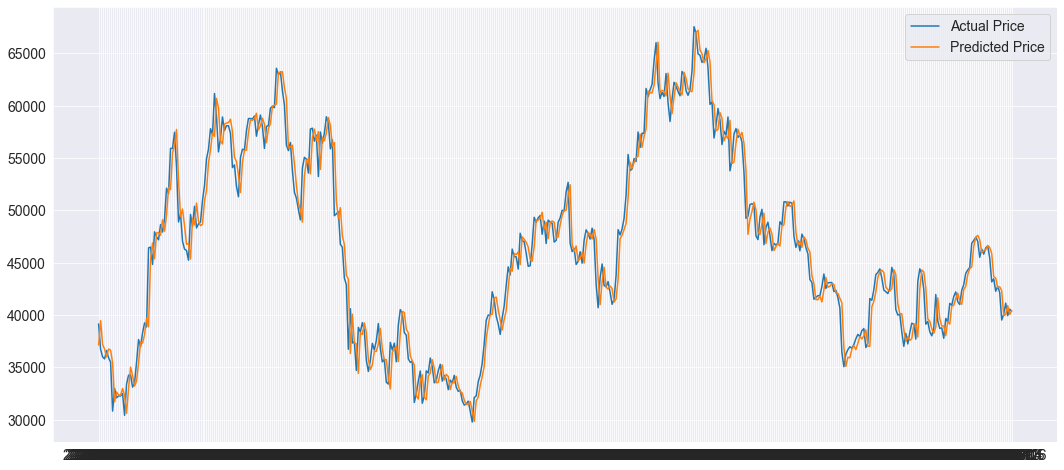

In [294]:
plt.plot(df_compare.index , df_compare.actual_price, label="Actual Price")
plt.plot(df_compare.index , df_compare.predicted_price, label="Predicted Price")
plt.legend()
plt.show()


# LIVE PREDICTION

* This section is trying to test the model performance on live prediction
* The model will predict the price the next day
* Therefore, there will be only one row of test set 
* y_test will be known at the end of trading day

#### 1. Dataset is from 2013 to Current day

In [295]:
btc_ml.head(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,994.95000,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,1000.32893,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435


In [296]:
btc_ml.tail(2)

,close,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-15,40569.9,41150.0,41480.0,39600.0,39954.9,1895.263567,20685.0,0.026730,-0.001646,0.000051,-0.029043,-0.214975,-0.138771,41636.885714,42330.428571,40535.685714,41132.114286,1966.503009,22213.571429,-0.01754,-0.012737,-0.011875,-0.006443,0.224060,0.040083,41619.333333,44189.960,42072.390
2022-04-16,40381.0,39953.7,40890.3,39800.0,40569.9,1177.171810,16024.0,-0.029072,-0.014216,0.005051,0.015392,-0.378888,-0.225332,41134.585714,41890.657143,40203.400000,40887.442857,1814.849922,20770.571429,-0.00644,-0.007910,-0.010630,-0.011553,0.287483,0.075320,41329.388889,43991.055,42116.972


#### 2. Training Set is from 2013 to yesterday price

<b> X_train</b>

In [297]:
X_train_new2 = btc_ml.drop(["close"], axis=1)
X_train_new2.head(2)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-11-27,801.59886,900.00000,768.58034,893.87025,13.846622,351.0,-0.004225,0.099752,0.052850,0.115109,0.275832,0.290441,727.991971,804.052834,671.933386,770.428236,32.574112,296.428571,0.084394,0.030572,0.064017,0.025034,0.056438,0.146473,742.279831,540.766110,319.194435
2013-11-28,893.90000,1081.09181,890.00000,994.95000,46.413145,782.0,0.115146,0.201213,0.157979,0.113081,2.351947,1.227920,772.591843,867.501920,734.790529,828.019664,31.094427,358.142857,0.025183,0.024414,0.075126,0.064433,0.047896,0.077178,775.052053,576.032168,336.653435


In [298]:
X_train_new2.tail(2)

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-15,41150.0,41480.0,39600.0,39954.9,1895.263567,20685.0,0.026730,-0.001646,0.000051,-0.029043,-0.214975,-0.138771,41636.885714,42330.428571,40535.685714,41132.114286,1966.503009,22213.571429,-0.01754,-0.012737,-0.011875,-0.006443,0.224060,0.040083,41619.333333,44189.960,42072.390
2022-04-16,39953.7,40890.3,39800.0,40569.9,1177.171810,16024.0,-0.029072,-0.014216,0.005051,0.015392,-0.378888,-0.225332,41134.585714,41890.657143,40203.400000,40887.442857,1814.849922,20770.571429,-0.00644,-0.007910,-0.010630,-0.011553,0.287483,0.075320,41329.388889,43991.055,42116.972


In [299]:
X_train2 = X_train_new2.values
X_train2.shape

(3053, 27)

<b> y_train </b>

In [300]:
y_train_new = btc_ml["close"]
y_train2 = y_train_new.values
y_train2.shape

(3053,)

#### 3. Test set is current trading day , today ( the last row)

In [301]:
X_test2 = last_row.drop(["close"], axis=1)
X_test2

,open_yesterday,high_yesterday,low_yesterday,close_yesterday,volume_yesterday,trades_yesterday,open_1D_change,high_1D_change,low_1D_change,close_1D_change,volume_1D_change,trades_1D_change,open_average_7D,high_average_7D,low_average_7D,close_average_7D,volume_average_7D,trades_average_7D,open_%change_7D,high_%change_7D,low_%change_7D,close_%change_7D,volume_%change_7D,trades_%change_7D,moving_average_9,moving_average_20,moving_average_50
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-04-17,40570.0,40708.8,40011.9,40381.0,589.463817,12703.0,0.015425,-0.004439,0.005324,-0.004656,-0.499254,-0.207252,40889.928571,41591.185714,39903.528571,40547.014286,1810.23817,20679.142857,-0.011554,-0.010097,-0.007823,-0.005453,0.171878,0.017501,40986.188889,43667.345,42139.922


<b> y_actual </b>

#### 4. Model Prediciton

In [302]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics  import mean_squared_error, r2_score
from sklearn.svm import SVR

### Scale featues

In [303]:
scaler = StandardScaler()

In [304]:
X_scaled_train2 = scaler.fit_transform(X_train2)

In [305]:
X_scaled_test2 = scaler.transform(X_test2) # not using fit to avoid data leakage 

In [306]:
param_grid2 = {'kernel': ['linear'], 'C': [100,300, 500], 'epsilon': [0.00001, 0.0001, 0.001]}

In [307]:
svr2 = SVR()

In [308]:
%%time
grid_search2 = GridSearchCV(svr2, param_grid2, cv=5, scoring='r2')

CPU times: user 22 µs, sys: 1 µs, total: 23 µs
Wall time: 24.8 µs


In [309]:
%%time
grid_search2.fit(X_scaled_train2, y_train2)

CPU times: user 1min 34s, sys: 194 ms, total: 1min 34s
Wall time: 1min 34s


GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [100, 300, 500],
                         'epsilon': [1e-05, 0.0001, 0.001],
                         'kernel': ['linear']},
             scoring='r2')

In [310]:
%%time
print(grid_search2.best_params_)

{'C': 500, 'epsilon': 0.001, 'kernel': 'linear'}
CPU times: user 38 µs, sys: 29 µs, total: 67 µs
Wall time: 57.2 µs


In [311]:
svr_best2 = grid_search2.best_estimator_

In [312]:
pred_svr_adjusted2 = svr_best2.predict(X_scaled_test2)

In [313]:
pred_svr_adjusted2

array([40412.25618367])

#### Create a new dataframe 

In [314]:
new_cols = ["date","predict", "actual"]

In [315]:
df_actual = pd.DataFrame(columns=new_cols)
df_actual

,date,predict,actual


In [316]:
df_actual["date"]= last_row.index
df_actual

,date,predict,actual
0,2022-04-17,NaN,NaN


In [317]:
df_actual["predict"] = pred_svr_adjusted2
df_actual

,date,predict,actual
0,2022-04-17,40412.256184,NaN


In [318]:
df_actual[0:1]["date"].values

array(['2022-04-17'], dtype=object)

In [319]:
x = np.asscalar(df_actual[0:1]["date"].values)
x

/var/folders/rk/_5r1csw96vn4r_l01g_prd_h0000gn/T/ipykernel_12914/3410238289.py:1: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  x = np.asscalar(df_actual[0:1]["date"].values)


'2022-04-17'

#### Call Kraken OHLCVVT API again at the end of day 
#### Run at the end of day

resp2 = requests.get('https://api.kraken.com/0/public/OHLC?pair=XBTUSD&interval=1440&since=unix_now').json()

xbt_new_df = pd.DataFrame(resp2["result"]['XXBTZUSD'])
xbt_new_df.columns = kraken_ohlc_cols
xbt_new_df["date"] = pd.to_datetime(xbt_new_df["date"],unit='s')
xbt_new_df.tail(10)

filter = xbt_new_df["date"]==x
filter

xbt_new_df[filter]

xbt_new_df[filter]["close"]

df_actual["actual"] = xbt_new_df[filter]["close"].values

df_actual

df_compare2 = pd.DataFrame(columns=new_cols )

df_compare2

df_compare2.append(df_actual)

print(np.sqrt(mean_squared_error(y_test2, pred_svr_adjusted2)))

print(r2_score(y_test2, pred_svr_adjusted2))

plt.plot(pred_svr_adjusted, label="SVR Predition Price")
plt.plot(y_test, label="Actual Close Price")
plt.legend()